# The Variance Gamma Partial Integro-Differential Equation

## Contents
   - [The VG PIDE](#sec1)
   - [Numerical solution of the PIDE](#sec2)
   - [Comparison with Monte Carlo, closed formula and Fourier inversion](#sec3)
   - [Comparison with the Black Scholes PDE](#sec4)  

I suggest the reader to read the notebook **3.1** on the Merton PIDE, and the Appendix **A3** for an introduction to the Variance Gamma (VG) process.

The knowledge of the VG process, is not necessary to understand this notebook, which is focused on the numerical solution of a PIDE.    
In my opinion the [wiki](https://en.wikipedia.org/wiki/Variance_gamma_process) page is not that clear, and if the reader is interested to understand something more, I really suggest the notebook **A3**.

Now I'm going to present an approximated equation, whose solution converges to the solution of the original VG equation for $\epsilon \to 0$.    The reason for using an approximation, is that the Lévy measure is singular in the origin.
Therefore, we have to remove the singularity from the integration region.  

<a id='sec1'></a>
## The VG PIDE   

The approximated VG PIDE has the following form:    

$$
  \frac{\partial V(t,x)}{\partial t} +
 \bigl( r-\frac{1}{2}\sigma_{\epsilon}^2 - w_{\epsilon} \bigr) \frac{\partial V(t,x)}{\partial x} 
 + \frac{1}{2}\sigma_{\epsilon}^2 \frac{\partial^2 V(t,x)}{\partial x^2}
 + \int_{|z| \geq \epsilon} V(t,x+z) \nu(dz) = (\lambda_{\epsilon} + r) V(t,x).
$$

with parameters   

$$
  \sigma_{\epsilon}^2 :=  \int_{|z| < \epsilon} z^2 \nu(dz), \quad \quad w_{\epsilon} := \int_{|z| \geq \epsilon} (e^z-1) \nu(dz), \quad \quad
 \lambda_{\epsilon} :=  \int_{|z| \geq \epsilon} \nu(dz) .
$$

and Lévy measure:   

$$
 \nu(dz) = \frac{e^{\frac{\theta z}{\sigma^2}}}{\kappa|z|} \exp 
 \left( - \frac{\sqrt{\frac{2}{\kappa} + \frac{\theta^2}{\sigma^2}}}{\sigma} |z|\right) dz,
$$

where I used the parametrization coming from the Brownian subordination. See equation [35] in **A3** or [wiki subordinator](https://en.wikipedia.org/wiki/Subordinator_(mathematics)).    
If you are reading quickly, and you have no time to study the Brownian subordination, just think of $\theta$, $\sigma$ and $\kappa$ as the three parameters of the model.

As I said before, the Lévy measure has a singularity at $z=0$.    

The activity of the VG process is infinite, i.e. $\lambda = \int_{-\infty}^{\infty} \nu(z) = \infty$. Since the interval $-\epsilon < z < \epsilon$ is removed from the region of integration, all the parameters defined above are finite! 

This equation is almost identical to the Merton PIDE, except for the truncation in the integral.

At this point, we can restrict the computational domain on $[A_1,A_2]$ and the integral region on $[-B_1,B_2]$, following the idea presented in **3.1**.   

Using the same discretization used for the Merton PIDE, we can solve the problem with the IMEX scheme.

I will not re-write the discrete equation. Everything will be clear (hopefully) from the following python code:

<a id='sec2'></a>
## Numerical solution of the PIDE

In [13]:
from scipy import sparse
from scipy.sparse.linalg import splu

import numpy as np
import scipy as scp
import scipy.stats as ss
from IPython.display import display
import sympy; sympy.init_printing()
from scipy import signal
from scipy.integrate import quad
import matplotlib.pyplot as plt

def display_matrix(m):
    display(sympy.Matrix(m))

In [14]:
r = 0.1                                         # risk free rate
theta = -0.1; sigma = 0.2; kappa = 0.1          # VG parameters 

W = - np.log(1 - theta * kappa - kappa/2 * sigma**2 ) /kappa    # martingale correction w

dev_X = np.sqrt(sigma**2 + theta**2 * kappa)     # std dev VG process

S0 = 100; X0 = np.log(S0)          # stock, log-price
K = 100; Texpir = 1                # strike and maturity

Nspace = 7                         # space steps 
Ntime = 3                          # time steps   
S_max = 3*float(K)                
S_min = float(K)/3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

dx = (x_max - x_min)/(Nspace-1)
extraP = int(np.floor(3*dev_X/dx))    # extra points
x = np.linspace(x_min-extraP*dx, x_max+extraP*dx, Nspace + 2*extraP)   # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)                    # time discretization

In **A3** we defined the "martingale correction" term:

\begin{equation}\label{parameter_w}
 w := \int_{\mathbb{R}} (e^z-1) \nu(dz) = - \frac{1}{\kappa} \log \left( 1-\theta \kappa -\frac{1}{2}\bar\sigma^2 \kappa \right).
\end{equation}

In the previous cell I defined $w$ (called `W`) just to compare it with $w_{\epsilon}$.  We expect that $w_{\epsilon} \to w$ as 
$\epsilon \to 0$.

Following Section 2.3 of **A.3**, I introduce the auxiliary parameters A and B.    
They will make the Lévy measure definition more readable.

In [3]:
A = theta/(sigma**2)
B = np.sqrt( theta**2 + 2*sigma**2/kappa ) / sigma**2

levy_m = lambda y: np.exp( A*y - B*np.abs(y) ) / (kappa*np.abs(y))   # Levy measure VG

The extra points are obtained by `extraP = int(np.floor(3*dev_X/dx))`, where `dev_X` is the standard deviation of the VG process. The choice of 3 stardard deviation is arbitrary, and in the pricer class this number is different (it is 5).

The extra points are the points in the intervals $[A_1 - B_1, A_1]$ and $[A_2, A_2 + B_2]$.   
In this case we have:

In [4]:
print("Under this discretization there are {} extra points".format(extraP))

Under this discretization there are 1 extra points


In [5]:
Payoff = np.maximum(np.exp(x)-K,0)             # Call payoff
V = np.zeros((Nspace + 2*extraP, Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms

V[:,-1] = Payoff                   # terminal conditions 
V[-extraP-1:,:] = np.exp(x[-extraP-1:]).reshape(extraP+1,1) * np.ones((extraP+1,Ntime)) - \
                 K * np.exp(-r* T[::-1] ) * np.ones((extraP+1,Ntime))  # boundary condition
V[:extraP+1,:] = 0

display_matrix(V.round(2))

⎡ 0.0     0.0     0.0  ⎤
⎢                      ⎥
⎢ 0.0     0.0     0.0  ⎥
⎢                      ⎥
⎢ 0.0     0.0     0.0  ⎥
⎢                      ⎥
⎢ 0.0     0.0     0.0  ⎥
⎢                      ⎥
⎢ 0.0     0.0     0.0  ⎥
⎢                      ⎥
⎢ 0.0     0.0    44.22 ⎥
⎢                      ⎥
⎢ 0.0     0.0    108.01⎥
⎢                      ⎥
⎢209.52  204.88  200.0 ⎥
⎢                      ⎥
⎣342.19  337.55  332.67⎦

Let us define the cutoff term $\epsilon$ and the relevant parameters.

Note:  The integrals are performed using the function `quad`. The integrals are split in the two regions: 
$[-B_1, -\epsilon]$ and $[\epsilon, B_2]$

In [6]:
eps = 1.5*dx    # the cutoff near 0

lam = quad(levy_m,-(extraP+1.5)*dx,-eps)[0] \
        + quad(levy_m,eps,(extraP+1.5)*dx)[0]       # approximated intensity lambda

int_w = lambda y: (np.exp(y)-1) * levy_m(y)                        # integrand of w_eps
int_s = lambda y: np.abs(y) * np.exp( A*y - B*np.abs(y) ) / kappa  # integrand of sigma_eps 
                                                                   # avoid division by zero

w = quad(int_w, -(extraP+1.5)*dx, -eps)[0] \
       + quad(int_w, eps, (extraP+1.5)*dx)[0]    #   w_eps

sig2 = quad(int_s,-eps,eps)[0]                   # the small jumps variance
sigJ = quad(int_s, -(extraP+1.5)*dx, -eps)[0] \
       + quad(int_s, eps, (extraP+1.5)*dx)[0]    # big jumps variance

Since we computed $\sigma_{\epsilon}^2 :=  \int_{|z| < \epsilon} z^2 \nu(dz)$ we can compute also $\sigma_J^2 = \int_{|z| \geq \epsilon} z^2 \nu(dz) $.    
We expect that $\sigma_{\epsilon}^2 + \sigma_J^2 = \mbox{dev_X}^2$.  
Due to the limitation of the integral in $[-B_1,B_2]$, the two are not perfectly equal. But for a big enough choice of $B_1$, $B_2$, the equality is satisfied, as we can see in the output of the cell below.

Let us inspect better the parameters we obtained:  

eps =  0.5493061443340548


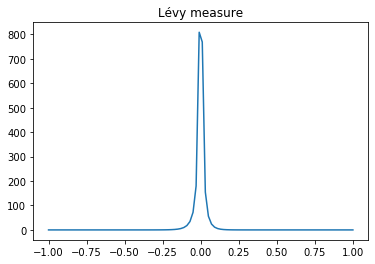

The intensity lam=0.000015 is very small because the mass is concentrated inside [-eps,eps].

Theoretical w:  -0.0796816964917688
Approximated w, w_eps =  -5.776003299341319e-06
Integral of int_w inside the truncation [-eps,eps]:  -0.07967591898305043


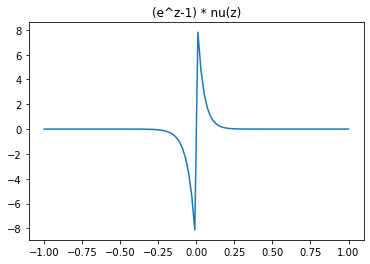

The VG variance 0.041000 is equal to the sum of the Var of the decomposed processes 0.041000.
Under this discretization the diffusion variance 0.040995 is the major component. 


In [7]:
print("eps = ", eps)
plt.plot(np.linspace(-1,1,100), levy_m(np.linspace(-1,1,100))); plt.title("Lévy measure"); plt.show()
print("The intensity lam={:.6f} \
is very small because the mass is concentrated inside [-eps,eps].".format(lam))
print("")

print("Theoretical w: ", W)
print("Approximated w, w_eps = ", w)
print("Integral of int_w inside the truncation [-eps,eps]: ", 
      quad(int_w, -eps, 1e-10)[0] + quad(int_w, 1e-10, eps)[0])
plt.plot(np.linspace(-1,1,100), int_w(np.linspace(-1,1,100))); plt.title("(e^z-1) * nu(z)"); plt.show()

print("The VG variance {0:.6f} is equal to the sum of the Var of the decomposed \
processes {1:.6f}.".format(sigJ + sig2, dev_X**2) )
print("Under this discretization the diffusion variance {:.6f} is the major component. ".format(sig2))

The parameter $w_{\epsilon}$ (i.e. w) is very different from the theoretical $w$ (i.e. W). This is a consequence of the discretization.    
I showed that the integral of $(e^z-1)\nu(dz)$ on $|z|>\epsilon$ is almost zero.     
It follows that the integral in the region $|z|<\epsilon$ is almost equal to $w$.

Ok... now that we have some confidence on this topic, we can continue with the solution of the PIDE.     
As usual we create the diffusion matrix:

In [8]:
dxx = dx * dx
a = ( (dt/2) * ( (r-w-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r + lam) )
c = (-(dt/2) * ( (r-w-0.5*sig2)/dx + sig2/dxx ) )
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
DD = splu(D)

In the following cell, I create the Lévy measure vector. 

The three points in the middle are zero!     
This is because the Lévy measure is truncated near the origin, and the region $[-\epsilon, \epsilon] = [-1.5\Delta x, 1.5\Delta x]$ is excluded.

In [9]:
nu = np.zeros(2*extraP+3)        # Lévy measure vector
x_med = extraP+1                 # middle point in nu vector
x_nu = np.linspace(-(extraP+1+0.5)*dx, (extraP+1+0.5)*dx, 2*(extraP+2) )    # integration domain

for i in range(len(nu)):
    if (i==x_med) or (i==x_med-1) or (i==x_med+1):
        continue
    nu[i] = quad(levy_m, x_nu[i], x_nu[i+1])[0]

display_matrix(nu)

⎡1.42095095888999e-5⎤
⎢                   ⎥
⎢        0.0        ⎥
⎢                   ⎥
⎢        0.0        ⎥
⎢                   ⎥
⎢        0.0        ⎥
⎢                   ⎥
⎣7.40395631195271e-7⎦

The following code is the same we used for the Merton PIDE. 

In [10]:
# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[extraP,i]
    offset[-1] = c * V[-1-extraP,i]
    V_jump = V[extraP+1 : -extraP-1, i+1] + dt * signal.convolve(V[:,i+1],nu[::-1],mode="valid",method="auto")
    V[extraP+1 : -extraP-1, i] = DD.solve( V_jump - offset ) 

In [11]:
# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print(oPrice)

10.326579506882776


##### All good!!

**Alternatively** we could have used the Jump matrix. 
Let us do it for completeness, but remember that the `signal.convolve` method is more efficient.

In [12]:
J = np.zeros((Nspace-2, Nspace + 2*extraP))

for i in range(Nspace-2):
    J[i, i:(len(nu)+i)] = nu

display_matrix(J)

⎡1.42095095888999e-5          0.0                  0.0                  0.0   
⎢                                                                             
⎢        0.0          1.42095095888999e-5          0.0                  0.0   
⎢                                                                             
⎢        0.0                  0.0          1.42095095888999e-5          0.0   
⎢                                                                             
⎢        0.0                  0.0                  0.0          1.420950958889
⎢                                                                             
⎣        0.0                  0.0                  0.0                  0.0   

       7.40395631195271e-7          0.0                  0.0                  
                                                                              
               0.0          7.40395631195271e-7          0.0                  
                                                   

In [13]:
# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[extraP,i]
    offset[-1] = c * V[-1-extraP,i]
    V_jump = V[extraP+1 : -extraP-1, i+1] + dt * (J @ V[:,i+1])
    V[extraP+1 : -extraP-1, i] = DD.solve( V_jump - offset )

In [14]:
# finds the ATM option at S0
oPrice = np.interp(X0, x, V[:,0])
print(oPrice)

10.326579506882776


<a id='sec3'></a>
## Comparison with Monte Carlo, closed formula and Fourier inversion


Let us compare the ATM prices obtained from different numerical methods. 

In [1]:
from functions.Parameters import Option_param
from functions.Processes import Diffusion_process, VG_process
from functions.BS_pricer import BS_pricer
from functions.VG_pricer import VG_pricer

In [18]:
# Creates the object with the parameters of the option
opt_param = Option_param(S0=100, K=100, T=1, exercise="European", payoff="call" )
# Creates the object with the parameters of the process
VG_param = VG_process(r=0.1, sigma=0.2, theta=-0.1, kappa=0.1)
# Creates the VG pricer
VG = VG_pricer(opt_param, VG_param)

PIDE price:  (it takes about 5 minutes to run)

In [8]:
VG.PIDE_price((30000,30000), Time=True)

(13.283337617834583, 279.2883496284485)

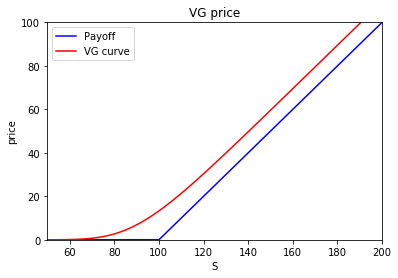

In [18]:
VG.plot([50,200,0,100])

**Closed formula**:

The semi-closed formula is a complicated expression presented in [1]. I will not describe it here.    
However, it doesn't work properly. It has a negative bias. Read comments below.

In [34]:
VG.closed_formula()

**Fourier inversion**:

In [19]:
VG.Fourier_inversion()

**Monte Carlo**:

(the output includes the price, the standard error and the execution time)

In [20]:
VG.MC(20000000,Err=True, Time=True)

The function `MC` uses the following code.

In [17]:
N = 10000000
rho = 1 / kappa; T = 1
w = -np.log(1 - theta * kappa - kappa/2 * sigma**2 ) /kappa  # martingale correction
G = ss.gamma(rho * T).rvs(N) / rho                # gamma random vector
Norm = ss.norm.rvs(0,1,N)                         # standard normal vector
VG_RV = theta * G + sigma * np.sqrt(G) * Norm     # VG vector obtained by subordination
S_T = S0 * np.exp( (r-w)*T + VG_RV )              # exponential dynamics
call = np.exp(-r*T) * scp.mean( np.maximum(S_T-K,0) )
put = np.exp(-r*T) * scp.mean( np.maximum(K-S_T,0) )
print("Monte Carlo, call: {}, put: {}".format(call,put))

Monte Carlo, call: 13.31239941535123, put: 3.8004051227363855


### Put option

In [4]:
opt_param_p = Option_param(S0=100, K=100, T=1, exercise="European", payoff="put" )
VG_p = VG_pricer(opt_param_p, VG_param)

In [5]:
print("PIDE price: ", VG_p.PIDE_price((12000,9000)) )
print("Fourier price: ", VG_p.Fourier_inversion() )
# the closed formula for the put is calculated by PUT/CALL parity
print("Closed formula price: ", VG_p.closed_formula() )  
print("MC price: ", VG_p.MC(10000000) )

PIDE price:  3.795310319468171
Fourier price:  3.797763745049398
Closed formula price:  3.7304537494501773
MC price:  3.7986397438339137


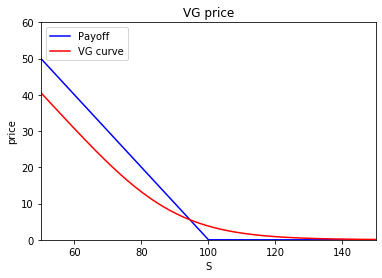

In [24]:
VG_p.plot([50,150,0,60])

### Remark:

There are some discrepancies between the outputs of the four numerical methods.    
In some cases the put/call parity is not satisfied.

- The Monte Carlo and Fourier prices are the most reliable

- The PIDE convergence in general is very slow.
  - For the put option we didn't need a huge grid in order to obtain the right price.
  - But for the call option I used a huge grid (30000x30000). I expect to have convergence with a higher grid resolution.

- The semi-closed formula used in VG_pricer is taken from [1]. In my opinion, this formula is not very accurate.     
  Unfortunately, I was not able to implement the closed formula proposed in the same paper [1], which relies on the     Bessel function of second kind (well...I tried, but it doesn't work. In VG_pricer it is called `closed_formula_wrong`).     
  Therefore I decided to use the semi-closed formula, which is based on numerical integration. 
  However, this formula still does not produce very accurate values. 

If you have any comment on these features, please let me know.

<a id='sec4'></a>
## Comparison with the Black Scholes PDE

Now let us compare the VG curve with the Black Scholes curve, for a European call option.    
The volatility of the BS model is chosen equal to the standard deviation of the VG process. 

In this case I'm going to select some parameters with the purpose to have high values of skewness and kurtosis for the VG distribution.    
In the VG process, the parameter $\theta$ is associated to the skewness, and the parameter $\kappa$ is associated to the kurtosis.

Looking at the plot we can notice the different shape of the two curves.

In [25]:
# Creates the object with the parameters of the option
opt_param = Option_param(S0=100, K=100, T=1, exercise="European", payoff="call" )

# Creates the object with the parameters of the process
VG_param2 = VG_process(r=0.1, sigma=0.2, theta=-0.2, kappa=2.5)
VG_param3 = VG_process(r=0.1, sigma=0.2, theta=+0.2, kappa=2.5)
diff_param = Diffusion_process(r=0.1, sig=np.sqrt(VG_param2.var))   

print("standard deviation: ", np.sqrt(VG_param2.var) )
print("skewness: ", VG_param2.skew)
print("kurtosis: ", VG_param2.kurt)
print("Changing the sign of theta, the skewness becomes: ", VG_param3.skew)

# Creates the object of the pricer
BS = BS_pricer(opt_param, diff_param)
VG2 = VG_pricer(opt_param, VG_param2)
VG3 = VG_pricer(opt_param, VG_param3)

standard deviation:  0.37416573867739417
skewness:  -3.05441419328485
kurtosis:  14.387755102040819
Changing the sign of theta, the skewness becomes:  3.05441419328485


In [26]:
BS.PDE_price((7000,4000), Time=True)

In [27]:
VG2.PIDE_price((14000,10000), Time=True)

In [28]:
VG3.PIDE_price((14000,10000), Time=True)

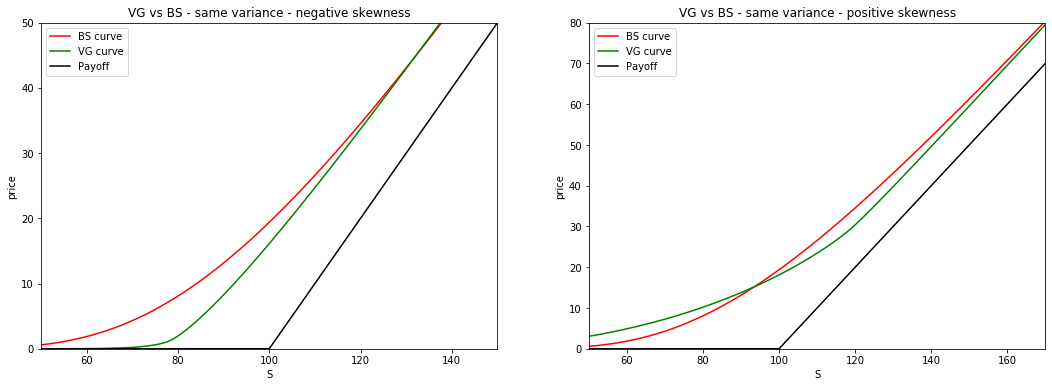

In [29]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(BS.S_vec, BS.price_vec, color='red',label="BS curve")
ax1.plot(VG2.S_vec, VG2.price_vec, color='green',label="VG curve")
ax1.plot(VG2.S_vec, VG2.payoff_f(VG2.S_vec), color='black',label="Payoff")
ax1.set_xlim(50,150); ax1.set_ylim(0,50)
ax1.set_xlabel("S"); ax1.set_ylabel("price"); ax1.set_title("VG vs BS - same variance - negative skewness")
ax1.legend()

ax2.plot(BS.S_vec, BS.price_vec, color='red',label="BS curve")
ax2.plot(VG3.S_vec, VG3.price_vec, color='green',label="VG curve")
ax2.plot(VG3.S_vec, VG3.payoff_f(VG3.S_vec), color='black',label="Payoff")
ax2.set_xlim(50,170); ax2.set_ylim(0,80)
ax2.set_xlabel("S"); ax2.set_ylabel("price"); ax2.set_title("VG vs BS - same variance - positive skewness")
ax2.legend()

plt.show()

[1]  Madan, D., Carr, P., and Chang, E. (1998). "The Variance Gamma process and option pricing". European Finance Review, 2, 79--105.